# 项目名： A股增强Alpha
## 介绍
利用zipline回测工具，实现A股数据的策略开发全过程。
所谓增强Alpha，顾名思义是基于验证过单因子有效性的多个alpha因子为基础，为了最大化超额收益，利用各种方式对alpha因子进行组合的策略。
此项目采用了随机森林和XGboost这两种集成学习（Ensemble Learning）算法。
参考[集成学习](https://www.cnblogs.com/zongfa/p/9304353.html).


## A股Data Bundle
Data bundle是Zipline回测平台特有的数据库存储方式。
此处利用A股csv格式的行情数据，生成自定义的Data Bundle，供之后策略开发使用。
### 数据预处理
CSV格式预处理，以适应Data Bundle的摄取(ingest)。

In [59]:
from   tqdm import tqdm
from   trading_calendars import get_calendar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pytz


country = "CN"
timezone = pytz.country_timezones(country)[0]
path_input = '/Users/tianjili/Desktop/FPaper/Code/data/'
path_out = '/Users/tianjili/Desktop/FPaper/Code/data_bundle/daily/'
file  = 'xxx'
SH_trade_calendar = get_calendar('XSHG')

for path,subdirs,files in os.walk(path_input):
    
    for i in tqdm(range(len(files))):
        file = files[i]
        file_FName_I = path_input + file
        file_FName_O = path_out   + file[4:]
        df= pd.DataFrame()
        df = df.from_csv(file_FName_I)
        df = df.reset_index().sort_values(by='date').drop(['amount','pchange'],axis=1)
        df['dividend'] = 0
        df['split'] = 1
        df['date'] = pd.to_datetime(df['date'])
        df['date'] = df.date.apply(lambda x: x.replace(tzinfo = pytz.utc).astimezone(timezone))
        df.set_index('date',inplace=True)
        actual_start_date = df.index[0]
        actual_end_date = df.index[-1]
        a=SH_trade_calendar.schedule.index>=actual_start_date 
        b=SH_trade_calendar.schedule.index<=actual_end_date
        
        calendar_trade_date = SH_trade_calendar.schedule.index[a*b]
        not_included_trade_date = calendar_trade_date.drop(df.index)
        
        #将start和end区间内的停牌数据生成一个空的DF，数据全是NAN就可以运行了。
        insert_df = pd.DataFrame(index=not_included_trade_date,columns=df.columns)
        
        df = pd.concat([df,insert_df])
        df['dividend'] = 0
        df['split'] = 1
        df = df.sort_index()
        
        df.to_csv(file_FName_O, header=True, index=True)

In [34]:
import shutil
import os
path_out = '/Users/tianjili/Desktop/FPaper/Code/data_bundle/daily/'
path_out_1 = '/Users/tianjili/Desktop/FPaper/Code/data_bundle/daily_1/'
for name in file_name:
    files = path_out + name + '.csv'
    shutil.move(files, path_out_1)

### 显示Bundles状态

In [1]:
!zipline bundles

csvdir <no ingestions>
quandl <no ingestions>
quantopian-quandl 2020-10-28 15:36:38.072482


### Bundle摄取数据
Zipline bundle ’custom-csvdir-bundle' 从1.2.1节处理好的CSV文件中摄取数据，以特殊形式存储在bundle中。

In [2]:
# !zipline ingest -b custom-csvdir-bundle

### 载入必要库

In [3]:
import sys
import project_helper
import project_tests

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 构建数据Pipeline
在线平台性能上很难满足大规模调试策略，加上机器学习或深度学习等计算密集型模型，所以本地回测如何提高效率是第一待解决的问题。
而zipline中的pipeline机制是很高效的。
### Bundle的注册
因为此项目我们用Zipline来处理数据，1.2章节中我们创建了数据Bundle。
此处我们需要注册创建的Bundle方便Zipline调用数据。

In [4]:
import sys
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join('C:/Users/ltjsu/.zipline')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], 'custom-csvdir-bundle')
bundles.register('custom-csvdir-bundle', ingest_func)

print('Data Registered')

Data Registered


### 创建Pipeline引擎
我们将运用Pipeline包来处理股票数据。此前，我们需要创建Pipeline引擎，方便之后使用。

In [5]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('XSHG')
bundle_data = bundles.load('custom-csvdir-bundle')
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

#### 查看数据
创建Pipeline引擎后，查看股票池最后一天的股票列表。

In [6]:
universe_end_date = pd.Timestamp('2020-10-27', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [000001]),
 Equity(1 [000002]),
 Equity(2 [000009]),
 Equity(3 [000011]),
 Equity(4 [000016]),
 Equity(5 [000021]),
 Equity(6 [000034]),
 Equity(7 [000063]),
 Equity(8 [000066]),
 Equity(9 [000069]),
 Equity(10 [000100]),
 Equity(11 [000157]),
 Equity(12 [000158]),
 Equity(13 [000166]),
 Equity(14 [000333]),
 Equity(15 [000338]),
 Equity(16 [000401]),
 Equity(17 [000425]),
 Equity(18 [000501]),
 Equity(19 [000513]),
 Equity(20 [000519]),
 Equity(21 [000538]),
 Equity(22 [000547]),
 Equity(23 [000555]),
 Equity(24 [000564]),
 Equity(25 [000568]),
 Equity(26 [000596]),
 Equity(27 [000625]),
 Equity(28 [000636]),
 Equity(29 [000651]),
 Equity(30 [000661]),
 Equity(31 [000672]),
 Equity(32 [000686]),
 Equity(33 [000725]),
 Equity(34 [000728]),
 Equity(35 [000733]),
 Equity(36 [000735]),
 Equity(37 [000738]),
 Equity(38 [000750]),
 Equity(39 [000768]),
 Equity(40 [000776]),
 Equity(41 [000783]),
 Equity(42 [000786]),
 Equity(43 [000789]),
 Equity(44 [000796]),
 Equity(45 [000799])

简单处理股票列表信息，方便获取申万行业数据。

In [7]:
Select_Stock = []

for i in range(len(universe_tickers)):
    Select_Stock.append(str(universe_tickers[i])[-8:-2])

Select_Stock[:10]

['000001',
 '000002',
 '000009',
 '000011',
 '000016',
 '000021',
 '000034',
 '000063',
 '000066',
 '000069']

### 获取收益率
构建DataPortal获取个股收益率数据。

In [8]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

自定义函数`get_pricing`获取股票收益率，增加代码可读性。

In [9]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

# Alpha因子
定义Alpha因子。此项目主要关注以下因子：
- 动量因子_1年
- 行业中性均值回归_5日平滑因子
- 隔夜情绪平滑因子

**此处务必保证，factor_start_date不是周末和节假日，不然后面会报错**

In [10]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing


factor_start_date = universe_end_date - pd.DateOffset(years=5, days=4)
print(factor_start_date)
sector = project_helper.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    unsmoothed_factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]
        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    unsmoothed_factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

2015-10-23 00:00:00+00:00


### 往Pipeline中添加因子
将以上因子添加到Pipeline中。

In [11]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

## 特征工程
定义一些对模型预测有帮助的特征。 好的基础特征能够作为显著的条件因子，对模型最终的预测有帮助。
### 一些”通用“量化特征
为了体现通用性，我们运用一下基础特征：
- 股票波动 20日平滑, 120日平滑
- 成交量量 20日平滑, 120日平滑
- 行业

In [12]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

### 市场特征
Regime Features
为了抓取市场特性，我们运用一下特征：
- 市场波动 20日平滑, 120日平滑
- 市场分散（离差） 20日平滑, 120日平滑

In [13]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

In [14]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

### 标签--预测目标
此项目对未来一周的收益做预测。因此量化目标过程中，因子追踪五日收益率。

In [15]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### 日期特征
因为日历异象（calendar anomalies）的存在，此处定义一些日期相关的特征。

**此处务必保证，factor_start_date不是周末和节假日，不然会报错**

In [16]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

all_factors.head(20)

Mean_Reversion_Sector_Neutral_Smoothed  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])                               0.59437882   
                          Equity(1 [000002])                               1.23519349   
                          Equity(2 [000009])                              -0.00928717   
                          Equity(3 [000011])                              -1.04016294   
                          Equity(4 [000016])                               1.71812628   
                          Equity(5 [000021])                               0.65010184   
                          Equity(6 [000034])                              -1.60668025   
                          Equity(7 [000063])                              -0.01857434   
                          Equity(8 [000066])                                      nan   
                          Equity(9 [000069])                               1.24448066   
                          Equity(10 [000100])                              1.31877801   
                          Equity(11 [000157])                             -0.87299389   
                          Equity(12 [000158])                             -0.94729125   
                          Equity(13 [000166])                              1.35592668   
                          Equity(14 [000333])                              0.29718941   
                          Equity(15 [000338])                              1.55095724   
                          Equity(16 [000401])                             -0.81727088   
                          Equity(17 [000425])                              1.52309573   
                          Equity(18 [000501])                             -0.27861507   
                          Equity(19 [000513])                                     nan   

                                               Momentum_1YR  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])    -1.01036778   
                          Equity(1 [000002])    -0.82860850   
                          Equity(2 [000009])     0.10157136   
                          Equity(3 [000011])    -0.76445816   
                          Equity(4 [000016])     0.92483400   
                          Equity(5 [000021])     1.01036778   
                          Equity(6 [000034])     1.64117942   
                          Equity(7 [000063])     0.05880447   
                          Equity(8 [000066])            nan   
                          Equity(9 [000069])    -0.63615749   
                          Equity(10 [000100])    0.93552573   
                          Equity(11 [000157])    0.63615749   
                          Equity(12 [000158])    1.32042774   
                          Equity(13 [000166])           nan   
                          Equity(14 [000333])    1.05313467   
                          Equity(15 [000338])   -1.68394631   
                          Equity(16 [000401])    0.52924027   
                          Equity(17 [000425])   -1.23489396   
                          Equity(18 [000501])   -0.05880447   
                          Equity(19 [000513])           nan   

                                               Overnight_Sentiment_Smoothed  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])                     0.54075914   
                          Equity(1 [000002])                     0.36186138   
                          Equity(2 [000009])                     1.68733114   
                          Equity(3 [000011])                    -0.80910578   
                          Equity(4 [000016])                    -0.73592033   
                          Equity(5 [000021])                     1.60601398   
                          Equity(6 [000034])                    -0.13417332   
                          Equity(7 [000063])                     1.43524793   
                          Equity(8 [000066])                    -1.21569159   
                          Equity(9 [000069])                   

In [17]:
all_factors['return_5d'].replace(to_replace=-1, value=np.nan, inplace=True)

### 行业信息独热编码
独热编码有助于模型更好的理解行业信息。

In [18]:
sector_lookup = pd.read_csv(
    os.path.join(os.getcwd(), 'data', 'project_7_sector', 'labels.csv'),
    index_col='Sector_i')['Sector'].to_dict()
sector_lookup

sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = '{}行业'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

采掘行业   化工行业   钢铁行业  有色金属行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])  False  False  False   False   
                          Equity(1 [000002])  False  False  False   False   
                          Equity(2 [000009])  False  False  False   False   
                          Equity(3 [000011])  False  False  False   False   
                          Equity(4 [000016])  False  False  False   False   

                                              建筑材料行业  建筑装饰行业  电气设备行业  机械设备行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])   False   False   False   False   
                          Equity(1 [000002])   False   False   False   False   
                          Equity(2 [000009])   False   False   False   False   
                          Equity(3 [000011])   False   False   False   False   
                          Equity(4 [000016])   False   False   False   False   

                                              国防军工行业   汽车行业  ...    公用事业行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])   False  False  ...     False   
                          Equity(1 [000002])   False  False  ...     False   
                          Equity(2 [000009])   False  False  ...     False   
                          Equity(3 [000011])   False  False  ...     False   
                          Equity(4 [000016])   False  False  ...     False   

                                              交通运输行业  房地产行业   电子行业  计算机行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])   False  False  False  False   
                          Equity(1 [000002])   False   True  False  False   
                          Equity(2 [000009])   False  False  False  False   
                          Equity(3 [000011])   False   True  False  False   
                          Equity(4 [000016])   False  False  False  False   

                                               传媒行业   通信行业   银行行业  非银金融行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])  False  False   True   False   
                          Equity(1 [000002])  False  False  False   False   
                          Equity(2 [000009])  False  False  False   False   
                          Equity(3 [000011])  False  False  False   False   
                          Equity(4 [000016])  False  False  False   False   

                                               综合行业  
2015-10-23 00:00:00+00:00 Equity(0 [000001])  False  
                          Equity(1 [000002])  False  
                          Equity(2 [000009])   True  
                          Equity(3 [000011])  False  
                          Equity(4 [000016])  False  

[5 rows x 28 columns]

### 日期平移
每日收益率往前平移5日（一周），作为模型目标。

In [19]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)

all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(30)

,level_0,level_1,return_5d,target
0,2015-10-23 00:00:00+00:00,Equity(0 [000001]),1.00000000,0.00000000
426,2015-10-26 00:00:00+00:00,Equity(0 [000001]),1.00000000,0.00000000
852,2015-10-27 00:00:00+00:00,Equity(0 [000001]),1.00000000,1.00000000
1278,2015-10-28 00:00:00+00:00,Equity(0 [000001]),0.00000000,1.00000000
1704,2015-10-29 00:00:00+00:00,Equity(0 [000001]),0.00000000,1.00000000
2130,2015-10-30 00:00:00+00:00,Equity(0 [000001]),0.00000000,1.00000000
2556,2015-11-02 00:00:00+00:00,Equity(0 [000001]),0.00000000,1.00000000
2982,2015-11-03 00:00:00+00:00,Equity(0 [000001]),1.00000000,1.00000000
3409,2015-11-04 00:00:00+00:00,Equity(0 [000001]),1.00000000,1.00000000
3836,2015-11-05 00:00:00+00:00,Equity(0 [000001]),1.00000000,0.00000000


### 目标独立相似分布（IID）检测
查看平移不同时长的收益率之间是否是独立同分布。

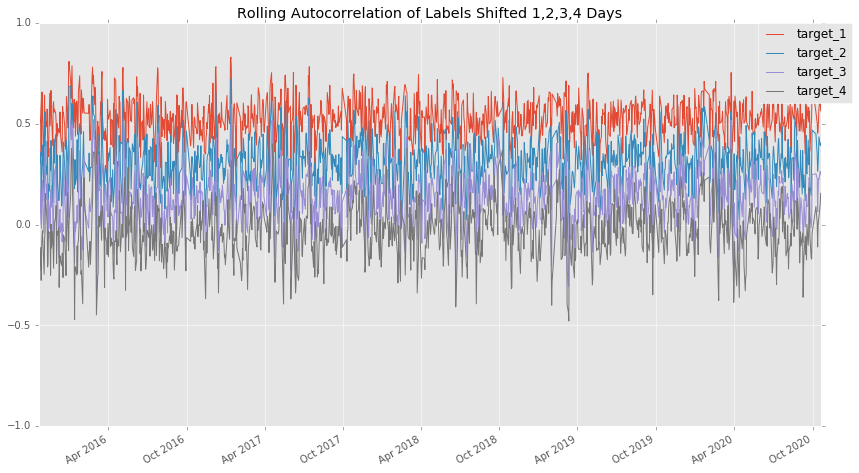

In [20]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)

g = all_factors.dropna().groupby(level=0)
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

### 标签平移对于自相关的影响
从上图中可以观察到：

$ 自相关{Target1} > 自相关{Target2} > 自相关{Target3} > 自相关{Target4}$

自相关随着您增加两次收益之间的间隔而减小。 自相关在正范围内，这意味着未来收益趋向于与过去收益相同的方向。此外，滞后1的自相关约在0.5附件振荡，滞后4的自相关约在0附近振荡，因此序列相关的程度从中等到非常低

这与股票收益通常表现出序列相关性是一致的

### 拆分训练集/验证集/测试集
将数据分为训练，验证和测试数据集。 实现函数“ train_valid_test_split”将输入样本“ all_x”和目标值“ all_y”分割为训练，验证和测试数据集。 比例大小分别是“ train_size”，“ valid_size”和“ test_size”。

分割时，请确保数据分别来自训练，验证和测试的顺序。 假设“ train_size”为0.7，“ valid_size”为0.2，而“ test_size”为0.1。 all_x和all_y的前70％是训练集合。 接下来的all_x和all_y 20％将是验证集。 all_x和all_y的最后10％是测试集。 确保不要将同一天分配给多个数据集，它应包含在单个数据集中。

In [21]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    train_inx = int(len(all_x) * train_size)
    valid_ind = int(len(all_x) * (train_size + valid_size))
    x_train = all_x[:train_inx]
    x_valid = all_x[train_inx:valid_ind]
    x_test  = all_x[valid_ind:]
    y_train = all_y[:train_inx]
    y_valid = all_y[train_inx:valid_ind]
    y_test  = all_y[valid_ind:]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test


project_tests.test_train_valid_test_split(train_valid_test_split)

Tests Passed


得到`train_valid_test_split`之后，就可以将数据拆分成训练集、验证集和测试集。
选取如下特征和5日收益率为预测目标。

In [22]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label].astype(int)

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])                              0.59437882   
                          Equity(1 [000002])                              1.23519349   
                          Equity(2 [000009])                             -0.00928717   
                          Equity(3 [000011])                             -1.04016294   
                          Equity(4 [000016])                              1.71812628   

                                              Momentum_1YR  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])   -1.01036778   
                          Equity(1 [000002])   -0.82860850   
                          Equity(2 [000009])    0.10157136   
                          Equity(3 [000011])   -0.76445816   
                          Equity(4 [000016])    0.92483400   

                                              Overnight_Sentiment_Smoothed  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])                    0.54075914   
                          Equity(1 [000002])                    0.36186138   
                          Equity(2 [000009])                    1.68733114   
                          Equity(3 [000011])                   -0.80910578   
                          Equity(4 [000016])                   -0.73592033   

                                                adv_120d     adv_20d  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])  1.45151137  0.87415951   
                          Equity(1 [000002])  1.59788226  1.15063786   
                          Equity(2 [000009])  0.86602779  1.54096025   
                          Equity(3 [000011]) -0.71152518 -0.54889085   
                          Equity(4 [000016]) -0.28054421  1.59788226   

                                              dispersion_120d  dispersion_20d  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])       0.04173601      0.03804019   
                          Equity(1 [000002])       0.04173601      0.03804019   
                          Equity(2 [000009])       0.04173601      0.03804019   
                          Equity(3 [000011])       0.04173601      0.03804019   
                          Equity(4 [000016])       0.04173601      0.03804019   

                                              market_vol_120d  market_vol_20d  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])       0.69036789      0.47614087   
                          Equity(1 [000002])       0.69036789      0.47614087   
                          Equity(2 [000009])       0.69036789      0.47614087   
                          Equity(3 [000011])       0.69036789      0.47614087   
                          Equity(4 [000016])       0.69036789      0.47614087   

                                              volatility_20d  ...    公用事业行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])     -1.66474872  ...     False   
                          Equity(1 [000002])     -1.67372311  ...     False   
                          Equity(2 [000009])      0.16602615  ...     False   
                          Equity(3 [000011])      0.80320760  ...     False   
                          Equity(4 [000016])      1.66474872  ...     False   

                                              交通运输行业  房地产行业   电子行业  计算机行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])   False  False  False  False   
                          Equity(1 [000002])   False   True  False  False   
                          Equity(2 [000009])   False  False  False  False   
                          Equity(3 [000011])   False   True  False  False   
                          Equity(4 [000016])   False  False  False  False   

                                               传媒行业   通信行业   银行行业  非银金融行业  \
2015-10-23 00:00:00+00:00 Equity(0 [000001])  False  False   True   False   
                          Equity(1 [000002])  False  False  False   False   
                          Equity(2 [000009])  False  False  False   False   
                      

In [23]:
y_train.value_counts()

1    146558
0    145344
Name: target, dtype: int64

# 集成学习
## 随即森林
### 决策树
单个决策树决策效果展示。

**对标的日期不做区分，使得此模型对股票种类不敏感，时序信息也丢失较多**

**对单一标定分别进行训练，将学习出属于不同标的的特性。高频数据将解决数据不够的问题**

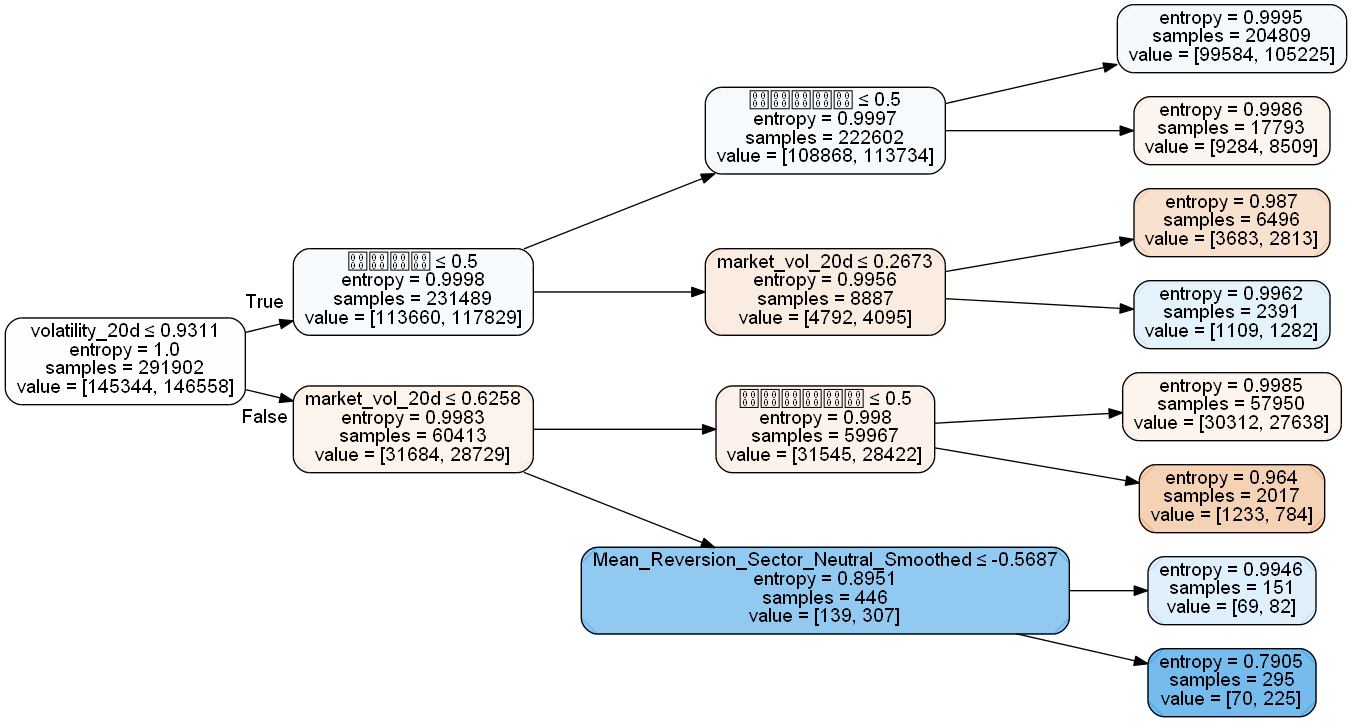

      Feature                                    Importance
 1. volatility_20d                         (0.3436750443254772)
 2. market_vol_20d                         (0.2524570548279559)
 3. 传媒行业                                   (0.13772600086036338)
 4. 计算机行业                                  (0.1325452624600904)
 5. 非银金融行业                                 (0.09848919179436515)
 6. Mean_Reversion_Sector_Neutral_Smoothed (0.03510744573174792)
 7. adv_120d                               (0.0)
 8. adv_20d                                (0.0)
 9. Momentum_1YR                           (0.0)
10. 化工行业                                   (0.0)
11. 采掘行业                                   (0.0)
12. qtr_start                              (0.0)
13. qtr_end                                (0.0)
14. month_start                            (0.0)
15. month_end                              (0.0)
16. weekday                                (0.0)
17. is_December                            (0.0)
18. is_Janaury

In [24]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier


# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(project_helper.plot_tree_classifier(simple_clf, feature_names=features))
project_helper.rank_features_by_importance(simple_clf.feature_importances_, features)

### 随机森林超参数 -- 决策树数量
定义不同参数，来确定最好的模型。
#### 参数
参见以下参数

In [25]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [10,20, 50, 100, 250, 500]

##### min_samples_leaf
min_samples_leaf ： 决策树每个叶--也就是决策树最底层样本数量。 足够小，有助于模型抓住数据细节；过于小，模型容易过拟合。
此参数的值以股票池股票数量的倍数为宜。当夏普率大于4的时候，往往是过拟合的征兆，因此建议设置为10倍股票数量。

次倍数可以调节，但过度调试也会在验证集上过拟合，从而降低模型泛化性，样本外数据表现很差。 因此倍数以指数的形式变动（10倍，20倍，100倍，而不是10倍11倍12倍...）。

In [26]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models:   0%|                                                                        | 0/6 [00:00<?, ?Model/s]C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
Training Models:  17%|██████████▋                                                     | 1/6 [00:03<00:19,  3.86s/Model]C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ltjsu\.conda\envs\zipline_en

##### n_trees_l
参考下图，分类器准确率随着决策树数量的变化。

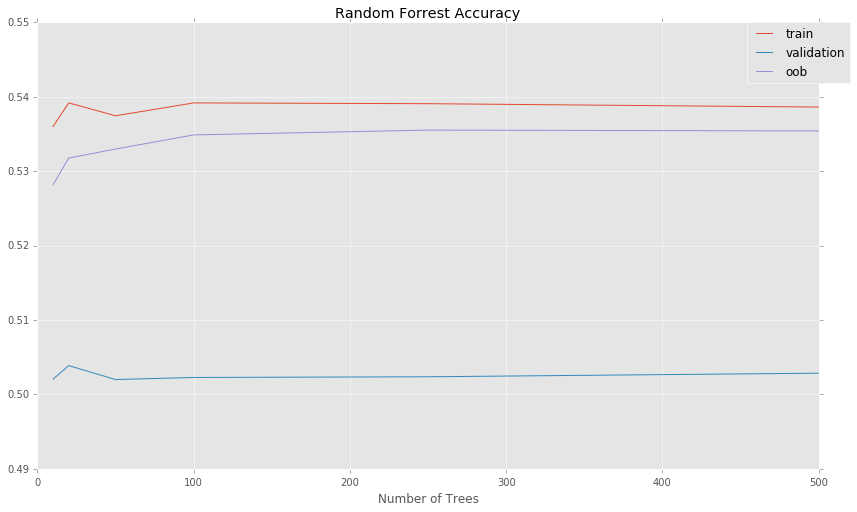

In [27]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

#### 判定过/欠拟合

- 图中验本外数据比验证集准确率高；决策树数量较少时，训练和样本外集准确率随着决策树增加而增加，而验证集下降，决策树数量较多时，准确率不在变化。
- 准确率的差值可以用来判定过/欠拟合（差距较大--过拟合；差距小--欠拟合）

下标展示，各特征的特征重要度在众多决策树上的均值。

In [28]:
print('Features Ranked by Average Importance:\n')
project_helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. volatility_20d                         (0.15698325411850958)
 2. market_vol_20d                         (0.1360756967500054)
 3. market_vol_120d                        (0.09052872223511906)
 4. adv_20d                                (0.08593050235075485)
 5. Momentum_1YR                           (0.07410572012433987)
 6. dispersion_20d                         (0.059806807268387545)
 7. dispersion_120d                        (0.05835963872406929)
 8. adv_120d                               (0.0545495154228221)
 9. Mean_Reversion_Sector_Neutral_Smoothed (0.04903090086792226)
10. Overnight_Sentiment_Smoothed           (0.04600774427958982)
11. 食品饮料行业                                 (0.03723726878442018)
12. 计算机行业                                  (0.036885078347025)
13. 国防军工行业                                 (0.03122574318998447)
14. 医药生物行业                                 (0.021140751568

上表中有些特征的特征重要度是0，之后的模型训练不在用这些特征。
### 模型结果
一下而外的指标讲用于衡量模型的预测能力。函数 `show_sample_results` 用来计算如下指标：
- 夏普率
- 因子回报率
- 因子自相关系数排序

**此处是用alphalens，评估模型性能，并不考虑交易成本**

In [29]:
import alphalens as al


all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing,max_loss=0.35):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    print(classifier.predict_proba(samples)[0])
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = '增强_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing,max_loss=max_loss)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)

C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\Users\ltjsu\.conda\envs\zipline_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


#### 预测效果
用一下几个因子与增强因子做个比较：

In [37]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d',
#     'market_vol_20d',
#     'market_vol_120d',
#     'dispersion_20d',
#     'dispersion_120d'，
    'adv_20d']

##### 训练
模型在训练集上训练。

[ 0.49702915  0.50297085]
Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss

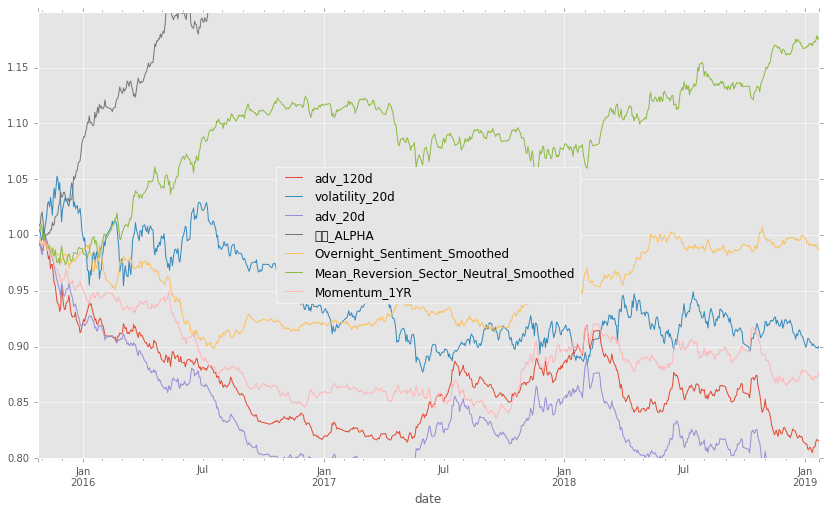

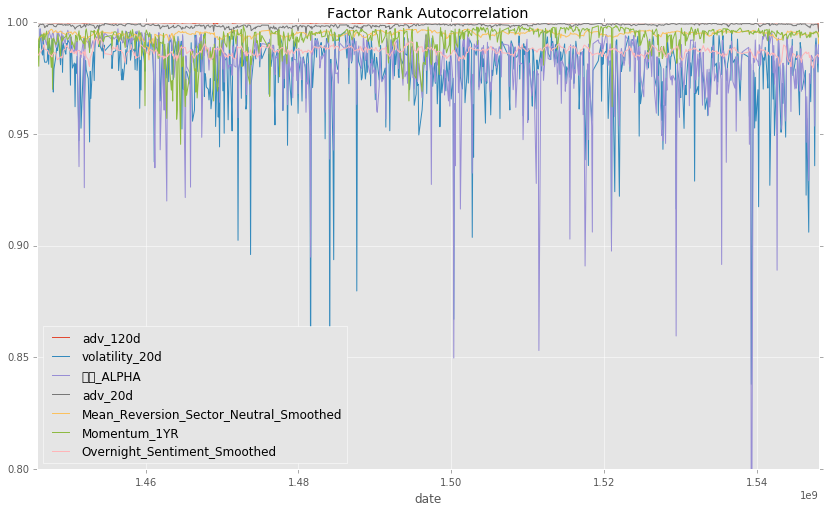

In [38]:
show_sample_results(all_factors, X_train, clf, factor_names,max_loss=0.4)

##### Validation Prediction
Let's see how well the model runs on validation data.

[ 0.49209595  0.50790405]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss

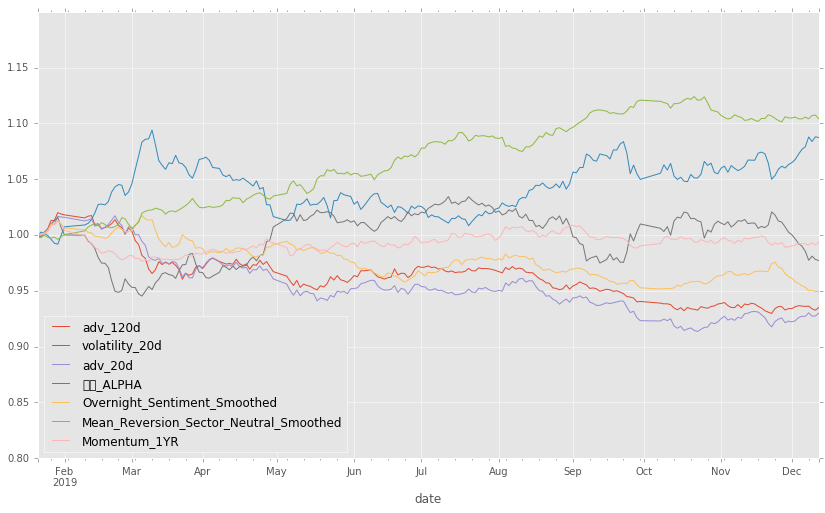

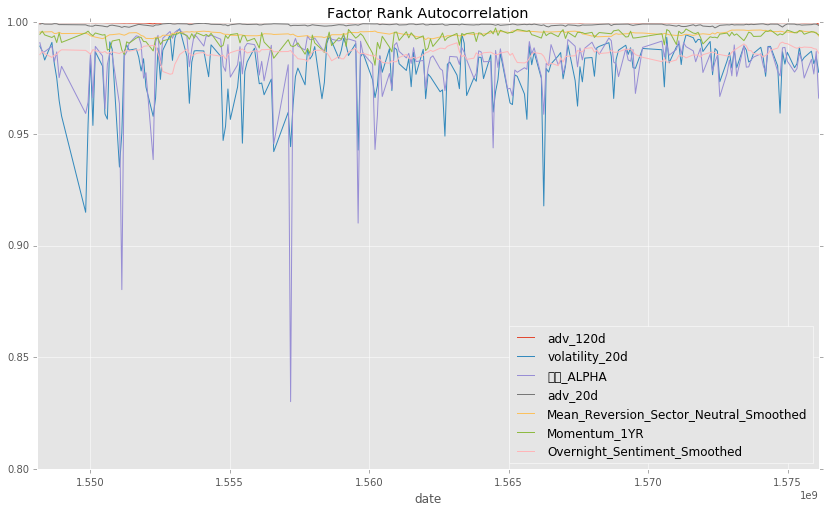

In [39]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Use BaggingClassifier's `max_samples`
- Build an ensemble of non-overlapping trees

In this project, we'll do all three methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

In [40]:
def non_overlapping_samples(x, y, n_skip_samples, start_i=0):
    """
    Get the non overlapping samples.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    n_skip_samples : int
        The number of samples to skip
    start_i : int
        The starting index to use for the data
    
    Returns
    -------
    non_overlapping_x : 2 dimensional Ndarray
        The non overlapping input samples
    non_overlapping_y : 1 dimensional Ndarray
        The non overlapping target values
    """
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    
    # TODO: Implement
    subsampled_idx = x.index.levels[0].tolist()[start_i :: n_skip_samples + 1]
    non_overlapping_x = x.loc[subsampled_idx]
    non_overlapping_y = y.loc[subsampled_idx]
    
    return non_overlapping_x, non_overlapping_y


project_tests.test_non_overlapping_samples(non_overlapping_samples)

AssertionError: Incorrect type for output non_overlapping_x, column test column 1
Type:          int32
EXPECTED Type: int64

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [49]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]


train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [00:19<00:00,  3.86s/Model]


#### Results

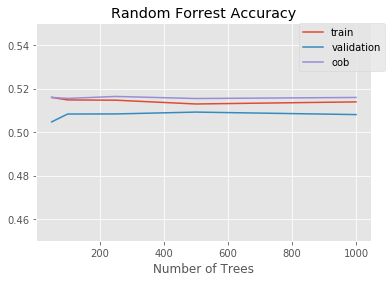

In [50]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

[0.49580794 0.50419206]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

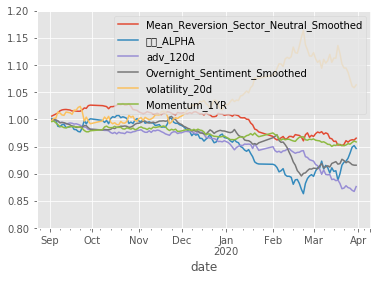

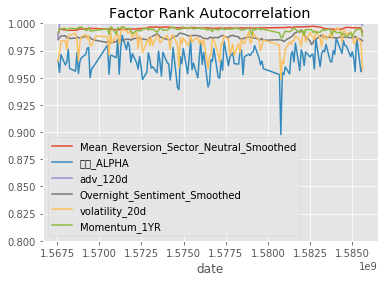

In [51]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Use BaggingClassifier's `max_samples`
In this method, we'll set `max_samples` to be on the order of the average uniqueness of the labels. Since  `RandomForrestClassifier` does not take this param, we're using `BaggingClassifier`. Implement `bagging_classifier` to build the bagging classifier.

In [52]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def bagging_classifier(n_estimators, max_samples, max_features, parameters):
    """
    Build the bagging classifier.

    Parameters
    ----------
    n_estimators : int 
        The number of base estimators in the ensemble
    max_samples : float 
        The proportion of input samples drawn from when training each base estimator
    max_features : float 
        The proportion of input sample features drawn from when training each base estimator
    parameters : dict
        Parameters to use in building the bagging classifier
        It should contain the following parameters:
            criterion
            min_samples_leaf
            oob_score
            n_jobs
            random_state
    
    Returns
    -------
    bagging_clf : Scikit-Learn BaggingClassifier
        The bagging classifier
    """
    
    required_parameters = {'criterion', 'min_samples_leaf', 'oob_score', 'n_jobs', 'random_state'}
    assert not required_parameters - set(parameters.keys())
    
    # TODO: Implement
    clf = DecisionTreeClassifier(criterion=parameters['criterion'], 
                                 min_samples_leaf=parameters['min_samples_leaf'], 
                                 random_state=parameters['random_state'])
    
    bagging_clf = BaggingClassifier(base_estimator=clf, 
                                    n_estimators=n_estimators, 
                                    max_samples=max_samples, 
                                    max_features=max_features, 
                                    oob_score=parameters['oob_score'],
                                    n_jobs=parameters['n_jobs'],
                                    random_state=parameters['random_state'])
    
    return bagging_clf


project_tests.test_bagging_classifier(bagging_classifier)

Tests Passed


With the bagging classifier built, lets train a new model and look at the results.
#### Train Model

In [53]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = bagging_classifier(n_trees, 0.2, 1.0, clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [06:15<00:00, 75.05s/Model]


#### Results

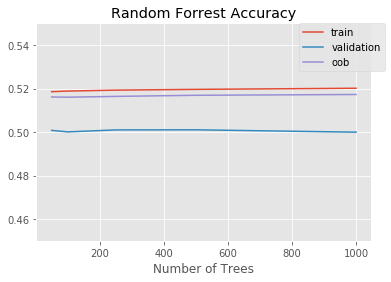

In [54]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

[0.48075271 0.51924729]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

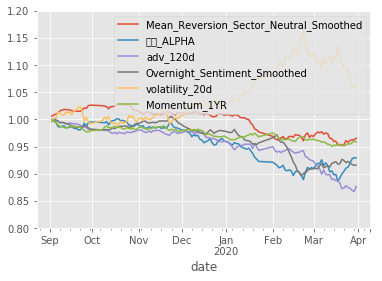

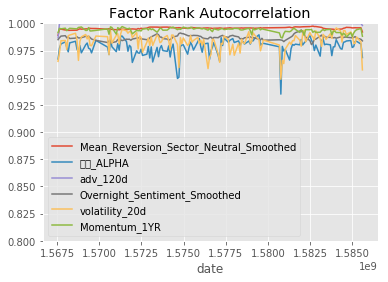

In [55]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This seems much "better" in the sense that we have much better fidelity between the three.


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [56]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

You might notice that two of the functions are abstracted. These will be the functions that you need to implement.
#### OOB Score
In order to get the correct OOB score, we need to take the average of all the estimator's OOB scores. Implement `calculate_oob_score` to calculate this score.

In [57]:
def calculate_oob_score(classifiers):
    """
    Calculate the mean out-of-bag score from the classifiers.

    Parameters
    ----------
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to calculate the mean out-of-bag score
    
    Returns
    -------
    oob_score : float
        The mean out-of-bag score
    """
    
    # TODO: Implement
    oob_score = 0
    for clf in classifiers:
        oob_score = oob_score + clf.oob_score_
    
    return oob_score / len(classifiers)


project_tests.test_calculate_oob_score(calculate_oob_score)

Tests Passed


#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [58]:
def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    """
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to fit on the non overlapping data
    n_skip_samples : int
        The number of samples to skip
    
    Returns
    -------
    fit_classifiers : list of Scikit-Learn Classifiers
        The classifiers fit to the the non overlapping data
    """
    
    # TODO: Implement
    fit_classifiers = []
    for start_idx, clf in enumerate(classifiers):
        X_resampled, y_resampled = non_overlapping_samples(x, y, n_skip_samples, start_idx)
        fit_classifiers.append(clf.fit(X_resampled, y_resampled))
        

    return fit_classifiers


# project_tests.test_non_overlapping_estimators(non_overlapping_estimators)

In [59]:
class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [60]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models:   0%|          | 0/5 [00:00<?, ?Model/s]/Users/tianjili/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/tianjili/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
Training Models:  20%|██        | 1/5 [00:06<00:26,  6.70s/Model]/Users/tianjili/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0`

#### Results

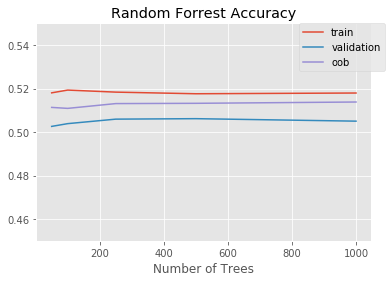

In [63]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

[0.49368656 0.50631344]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

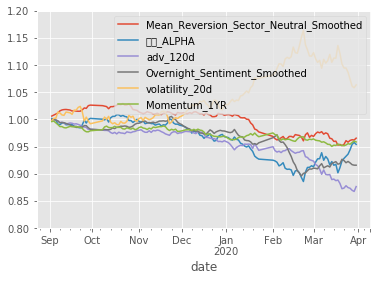

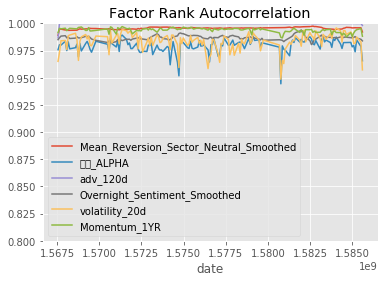

In [62]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [64]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

### Results
#### Accuracy

In [65]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

/Users/tianjili/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train: 0.517796296199665, oob: 0.518800876643707, valid: 0.5129989518924546


/Users/tianjili/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Train

[0.49731067 0.50268933]
Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

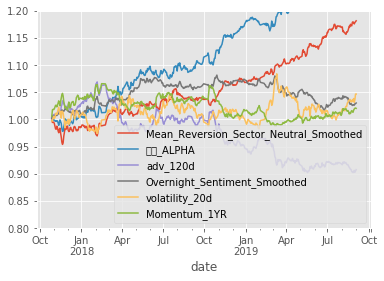

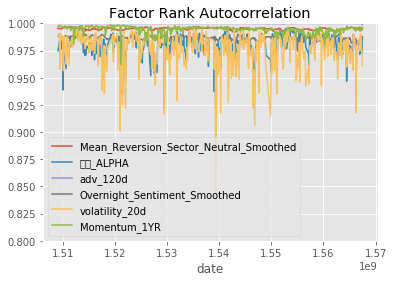

In [66]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

[0.49589671 0.50410329]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

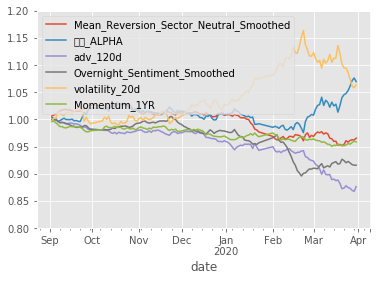

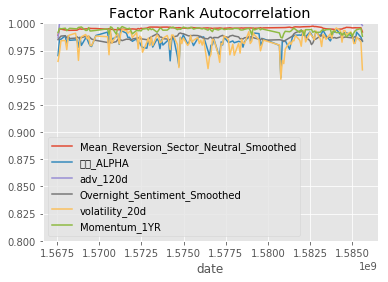

In [67]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

[0.49047583 0.50952417]
Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss i

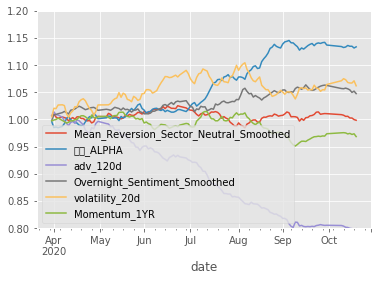

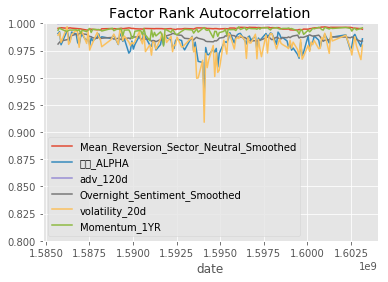

In [68]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

So, hopefully you are appropriately amazed by this. Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.